## 1. import each dataset, cause it's large

In [3]:
from collections import defaultdict

def build_pairs(names):
    pairs = defaultdict(dict)
    for name in names:
        if name.startswith("raw_review_"):
            cat = name.replace("raw_review_", "")
            pairs[cat]["review"] = name
        elif name.startswith("raw_meta_"):
            cat = name.replace("raw_meta_", "")
            pairs[cat]["meta"] = name
    return pairs

with open("datasets.txt", "r") as f:
    names = [line.strip() for line in f if line.strip()]

pairs = build_pairs(names)

for i, (cat, pair) in enumerate(pairs.items()):
    if i == 10: break
    print(cat, "=>", pair)


All_Beauty => {'meta': 'raw_meta_All_Beauty', 'review': 'raw_review_All_Beauty'}
Toys_and_Games => {'meta': 'raw_meta_Toys_and_Games', 'review': 'raw_review_Toys_and_Games'}
Cell_Phones_and_Accessories => {'meta': 'raw_meta_Cell_Phones_and_Accessories', 'review': 'raw_review_Cell_Phones_and_Accessories'}
Industrial_and_Scientific => {'meta': 'raw_meta_Industrial_and_Scientific', 'review': 'raw_review_Industrial_and_Scientific'}
Gift_Cards => {'meta': 'raw_meta_Gift_Cards', 'review': 'raw_review_Gift_Cards'}
Musical_Instruments => {'meta': 'raw_meta_Musical_Instruments', 'review': 'raw_review_Musical_Instruments'}
Electronics => {'meta': 'raw_meta_Electronics', 'review': 'raw_review_Electronics'}
Handmade_Products => {'meta': 'raw_meta_Handmade_Products', 'review': 'raw_review_Handmade_Products'}
Arts_Crafts_and_Sewing => {'meta': 'raw_meta_Arts_Crafts_and_Sewing', 'review': 'raw_review_Arts_Crafts_and_Sewing'}
Baby_Products => {'meta': 'raw_meta_Baby_Products', 'review': 'raw_review_Ba

In [4]:
from datasets import load_dataset

category = "CDs_and_Vinyl"
review_name = pairs[category]["review"]
meta_name = pairs[category]["meta"] 
# Load CDs_and_Vinyl reviews
dataset_review = load_dataset("McAuley-Lab/Amazon-Reviews-2023", review_name, split="full")
dataset_meta = load_dataset("McAuley-Lab/Amazon-Reviews-2023", meta_name, split="full")
print(dataset_review)
print(dataset_meta)
print("Number of feature in dataset_review:", len(dataset_review.features))
print("Number of feature in dataset_meta:", len(dataset_meta.features))

# Count unique users and items
n_users = len(set(dataset_review["user_id"]))
n_items = len(set(dataset_review["asin"]))
n_reviews = len(dataset_review)

n_categories = len(set(dataset_meta["main_category"]))

print(f"#Categories: {n_categories:,}")
print(f"#Users: {n_users:,}")
print(f"#Items: {n_items:,}")
print(f"#Reviews: {n_reviews:,}")


Dataset({
    features: ['rating', 'title', 'text', 'images', 'asin', 'parent_asin', 'user_id', 'timestamp', 'helpful_vote', 'verified_purchase'],
    num_rows: 4827273
})
Dataset({
    features: ['main_category', 'title', 'average_rating', 'rating_number', 'features', 'description', 'price', 'images', 'videos', 'store', 'categories', 'details', 'parent_asin', 'bought_together', 'subtitle', 'author'],
    num_rows: 701959
})
Number of feature in dataset_review: 10
Number of feature in dataset_meta: 16
#Categories: 30
#Users: 1,754,118
#Items: 701,706
#Reviews: 4,827,273


## 2. EDA


In [5]:
import pandas as pd
df_review = dataset_review.to_pandas()
df_meta = dataset_meta.to_pandas()
print(df_review.head())

   rating              title  \
0     5.0         Five Stars   
1     5.0         Five Stars   
2     3.0        Three Stars   
3     3.0       Disappointed   
4     5.0  Wonderful melding   

                                                text images        asin  \
0                                           LOVE IT!     []  B002MW50JA   
1                                             LOVE!!     []  B008XNPN0S   
2  Sad there is not the versions with the real/or...     []  B00IKM5N02   
3  I have listen to The Broadway 1958 Flower Drum...     []  B00006JKCM   
4  Simply great album. One of the best. Marvelous...     []  B00013YRQY   

  parent_asin                       user_id      timestamp  helpful_vote  \
0  B002MW50JA  AGKASBHYZPGTEPO6LWZPVJWB2BVA  1452650777000             0   
1  B008XNPN0S  AGKASBHYZPGTEPO6LWZPVJWB2BVA  1452650764000             0   
2  B00IKM5N02  AGKASBHYZPGTEPO6LWZPVJWB2BVA  1452649885000             0   
3  B00006JKCM  AEVWAM3YWN5URJVJIZZ6XPD2MKIA  1164036

In [6]:
df_meta = df_meta[['parent_asin','main_category','title','average_rating','rating_number','features','description','price','images','categories','store']]
df_review =df_review[['asin','parent_asin','user_id','rating','title','text','timestamp','helpful_vote','verified_purchase','images']]
df_meta = df_meta.dropna(subset = ['parent_asin']).drop_duplicates(subset = ['parent_asin'])
df = df_review.merge(df_meta, on= 'parent_asin', how='left')
df.count()
df = df.sample(5000, random_state=42).reset_index(drop=True)

## import CLIP model

In [7]:
import io, time, math, requests
from PIL import Image
import numpy as np
import pandas as pd
import torch
from tqdm import tqdm
from transformers import CLIPModel, CLIPProcessor
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device).eval()
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")



Using device: cuda


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


## pick the best url for image chopped down 

In [8]:

import numpy as np

def pick_best_image_from_images_field(images_field):
    """
    Returns a single best URL given one row's images field.
    Prefers hi_res MAIN -> hi_res any -> large MAIN -> large any -> thumb MAIN -> thumb any.
    Returns None if nothing usable.
    """
    if images_field is None:
        return None

    # Some splits may store images as a plain list of URLs (reviews_x). Handle that too.
    if isinstance(images_field, (list, tuple)):
        return images_field[0] if images_field else None

    # Expect dict with arrays
    if isinstance(images_field, dict):
        # Normalize to python lists
        def to_list(x):
            if x is None: return []
            if isinstance(x, np.ndarray): return x.tolist()
            if isinstance(x, (list, tuple)): return list(x)
            return []

        hi_res   = to_list(images_field.get('hi_res'))
        large    = to_list(images_field.get('large'))
        thumb    = to_list(images_field.get('thumb'))
        variant  = to_list(images_field.get('variant'))

        # If no variant provided, just prefer hi_res->large->thumb by first URL
        if not variant:
            for arr in (hi_res, large, thumb):
                if arr: return arr[0]
            return None

        # Build aligned records
        L = max(len(hi_res), len(large), len(thumb), len(variant))
        recs = []
        for i in range(L):
            v = variant[i] if i < len(variant) else None
            recs.append({
                'variant': v,
                'hi_res': hi_res[i] if i < len(hi_res) else None,
                'large':  large[i]  if i < len(large)  else None,
                'thumb':  thumb[i]  if i < len(thumb)  else None,
            })

        # Priority helpers
        def first_where(key, cond=lambda r: True):
            for r in recs:
                if cond(r) and r.get(key): return r[key]
            return None

        # Try in order of preference
        return ( first_where('hi_res',  lambda r: r['variant'] == 'MAIN')
              or first_where('hi_res')
              or first_where('large',   lambda r: r['variant'] == 'MAIN')
              or first_where('large')
              or first_where('thumb',   lambda r: r['variant'] == 'MAIN')
              or first_where('thumb') )

    # Fallback: unknown type
    return None

## 
df['img_url'] = df['images_y'].apply(pick_best_image_from_images_field)


In [ ]:
import os, io, requests
from concurrent.futures import ThreadPoolExecutor, as_completed
from PIL import Image
import numpy as np
import torch

SESSION = requests.Session()
SESSION.headers.update({"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/119 Safari/537.36"})

def fetch_image_bytes(url, timeout=2.5, max_kb=4096):
    try:
        r = SESSION.get(url, timeout=timeout, stream=True)
        r.raise_for_status()
        b = r.content
      
        # Max cap ~4 MB (change if needed)
        if len(b) > max_kb * 1024:
            return 
        return b
    except Exception:
        return None

def to_pil(b):
    if b is None:
        return None
    try:
        return Image.open(io.BytesIO(b)).convert("RGB")
    except Exception:
        return None


# day la ham push cai hinh anh vao trong cai model clip
@torch.no_grad()
def embed_pil_batch(pil_list, batch_size=64 if torch.cuda.is_available() else 16):
    # keep positions of valid PILs
    keep_idx, images = [], []
    for i, im in enumerate(pil_list):
        if im is not None:
            keep_idx.append(i)
            images.append(im)

    embs = [None] * len(pil_list)
    for i in range(0, len(images), batch_size):
        batch = images[i:i+batch_size]
        inputs = processor(images=batch, return_tensors="pt").to(device)
        feats = model.get_image_features(**inputs)
        feats = torch.nn.functional.normalize(feats, p=2, dim=1).cpu().numpy()
        for j, vec in enumerate(feats):
            embs[keep_idx[i+j]] = vec
    return embs


mask = df["img_url"].notna()
work = df.loc[mask, ["parent_asin", "img_url"]].drop_duplicates("parent_asin").copy()

# SAMPLE SIZE — tuy` chinh theo kha` nang xu ly
SAMPLE = 5000
if len(work) > SAMPLE:
    work = work.sample(SAMPLE, random_state=42).reset_index(drop=True)

print("Images to process:", len(work))

# Parallel download (fast I/O)
# Download images in parallel threads va dc store duoi dang bytes, sau do chuyen thanh PIL
N_WORKERS = 48  # try 32–64; lower if network throttles

bytes_list = [None] * len(work)
with ThreadPoolExecutor(max_workers=N_WORKERS) as ex:
    futs = {ex.submit(fetch_image_bytes, url): i for i, url in enumerate(work["img_url"])}
    for fut in tqdm(as_completed(futs), total=len(futs), desc="Downloading"):
        i = futs[fut]
        bytes_list[i] = fut.result()

# Convert to PIL
work["pil"] = [to_pil(b) for b in bytes_list]
ok_rate = work["pil"].notna().mean()
print(f"Download OK rate: {ok_rate:.1%}")

# Batched CLIP embedding (with periodic checkpoints)
# chia batch ra 2000
EMBATCH = 2000   # rows per embedding chunk (not CLIP batch)
vecs = [None] * len(work)
for s in range(0, len(work), EMBATCH):
    sub = work.iloc[s:s+EMBATCH]
    embs = embed_pil_batch(sub["pil"].tolist())
    for j, v in enumerate(embs):
        vecs[s + j] = v

work["clip_img_emb"] = vecs
work = work.drop(columns=["pil"])

# Keep only successful embeddings, one per parent_asin
emb_df = work.loc[work["clip_img_emb"].notna(), ["parent_asin", "clip_img_emb"]].drop_duplicates("parent_asin")

# Save (parquet with list-of-floats)
emb_out = emb_df.copy()
emb_out["clip_img_emb"] = emb_out["clip_img_emb"].apply(lambda v: v.tolist())
emb_out.to_parquet("clip_img_emb_parent.parquet", index=False)
print("Saved embeddings:", len(emb_out))

#merge back to df
df["parent_asin"] = df["parent_asin"].astype(str)
emb_out["parent_asin"] = emb_out["parent_asin"].astype(str)

df = df.merge(emb_out, on="parent_asin", how="left")
df["has_img_emb"] = df["clip_img_emb"].notna().astype(int)
df["clip_img_emb"] = df["clip_img_emb"].apply(lambda v: v if isinstance(v, np.ndarray) else np.zeros(512, dtype=np.float32))
# save final df
df.to_parquet(f"reviews_with_img_emb_{category}.parquet", index=False)
print("Final coverage in df (has_img_emb):", df["has_img_emb"].mean())


Images to process: 4746
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>


Downloading:   1%|          | 45/4746 [00:00<00:10, 433.86it/s]

<class 'bytes'><class 'bytes'>
<class 'bytes'>

<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'><class 'bytes'>
<class 'bytes'>

<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>


Downloading:   2%|▏         | 89/4746 [00:00<00:14, 324.11it/s]

<class 'bytes'><class 'bytes'>
<class 'bytes'>

<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>


Downloading:   3%|▎         | 124/4746 [00:00<00:14, 329.05it/s]

<class 'bytes'><class 'bytes'>
<class 'bytes'>

<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>


Downloading:   4%|▍         | 196/4746 [00:00<00:13, 342.16it/s]

<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'><class 'bytes'>

<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class '

Downloading:   5%|▍         | 232/4746 [00:00<00:13, 347.16it/s]

<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>


Downloading:   6%|▌         | 268/4746 [00:00<00:13, 319.96it/s]

<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>


Downloading:   6%|▋         | 301/4746 [00:00<00:15, 291.43it/s]

<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>


Downloading:   8%|▊         | 368/4746 [00:01<00:14, 300.10it/s]

<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class '

Downloading:   9%|▉         | 430/4746 [00:01<00:15, 286.99it/s]

<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>


Downloading:  10%|█         | 497/4746 [00:01<00:14, 295.24it/s]

<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class '

Downloading:  12%|█▏        | 563/4746 [00:01<00:13, 312.51it/s]

<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>


Downloading:  13%|█▎        | 595/4746 [00:01<00:13, 311.32it/s]

<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>


Downloading:  13%|█▎        | 627/4746 [00:02<00:15, 263.33it/s]

<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>


Downloading:  14%|█▍        | 660/4746 [00:02<00:14, 272.79it/s]

<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>


Downloading:  15%|█▍        | 689/4746 [00:02<00:15, 260.19it/s]

<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>


Downloading:  15%|█▌        | 719/4746 [00:02<00:15, 268.46it/s]

<class 'bytes'><class 'bytes'>
<class 'bytes'>

<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>


Downloading:  16%|█▌        | 747/4746 [00:02<00:15, 258.69it/s]

<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>


Downloading:  16%|█▋        | 780/4746 [00:02<00:14, 277.78it/s]

<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class '

Downloading:  18%|█▊        | 848/4746 [00:02<00:12, 303.57it/s]

<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>


Downloading:  19%|█▊        | 879/4746 [00:03<00:19, 196.77it/s]

<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>


Downloading:  20%|█▉        | 928/4746 [00:03<00:23, 160.40it/s]

<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>


Downloading:  21%|██        | 976/4746 [00:03<00:20, 187.90it/s]

<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>


Downloading:  22%|██▏       | 1025/4746 [00:03<00:17, 209.87it/s]

<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>


Downloading:  23%|██▎       | 1073/4746 [00:04<00:18, 200.84it/s]

<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>


Downloading:  24%|██▎       | 1123/4746 [00:04<00:16, 216.52it/s]

<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>


Downloading:  25%|██▍       | 1171/4746 [00:04<00:16, 216.22it/s]

<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>


Downloading:  25%|██▌       | 1194/4746 [00:04<00:16, 211.58it/s]

<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>


Downloading:  26%|██▋       | 1251/4746 [00:04<00:13, 249.80it/s]

<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>


Downloading:  28%|██▊       | 1306/4746 [00:05<00:14, 236.05it/s]

<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>


Downloading:  28%|██▊       | 1331/4746 [00:05<00:14, 229.13it/s]

<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>


Downloading:  30%|██▉       | 1405/4746 [00:05<00:14, 227.19it/s]

<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>


Downloading:  30%|███       | 1434/4746 [00:05<00:13, 244.25it/s]

<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>


Downloading:  31%|███       | 1459/4746 [00:05<00:14, 227.09it/s]

<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>


Downloading:  32%|███▏      | 1507/4746 [00:06<00:16, 193.63it/s]

<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>


Downloading:  33%|███▎      | 1565/4746 [00:06<00:13, 227.30it/s]

<class 'bytes'><class 'bytes'>

<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>


Downloading:  35%|███▍      | 1642/4746 [00:06<00:12, 240.90it/s]

<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>


Downloading:  35%|███▌      | 1668/4746 [00:06<00:13, 232.56it/s]

<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>


Downloading:  36%|███▌      | 1715/4746 [00:07<00:13, 220.74it/s]

<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>


Downloading:  37%|███▋      | 1765/4746 [00:07<00:14, 211.67it/s]

<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>


Downloading:  38%|███▊      | 1787/4746 [00:07<00:15, 187.32it/s]

<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>


Downloading:  39%|███▊      | 1839/4746 [00:07<00:14, 197.72it/s]

<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>


Downloading:  40%|███▉      | 1888/4746 [00:07<00:13, 215.96it/s]

<class 'bytes'><class 'bytes'>

<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>


Downloading:  41%|████      | 1940/4746 [00:08<00:12, 233.48it/s]

<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>


Downloading:  42%|████▏     | 1989/4746 [00:08<00:11, 232.34it/s]

<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>


Downloading:  43%|████▎     | 2037/4746 [00:08<00:12, 218.36it/s]

<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>


Downloading:  44%|████▍     | 2084/4746 [00:08<00:12, 218.49it/s]

<class 'bytes'><class 'bytes'>

<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>


Downloading:  45%|████▍     | 2131/4746 [00:09<00:11, 222.23it/s]

<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>


Downloading:  46%|████▋     | 2206/4746 [00:09<00:10, 238.41it/s]

<class 'bytes'><class 'bytes'>

<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>


Downloading:  47%|████▋     | 2230/4746 [00:09<00:10, 235.04it/s]

<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>


Downloading:  48%|████▊     | 2279/4746 [00:09<00:12, 202.26it/s]

<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>


Downloading:  49%|████▉     | 2325/4746 [00:09<00:11, 212.66it/s]

<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>


Downloading:  50%|█████     | 2379/4746 [00:10<00:09, 241.64it/s]

<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>


Downloading:  51%|█████▏    | 2433/4746 [00:10<00:09, 233.44it/s]

<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>


Downloading:  52%|█████▏    | 2491/4746 [00:10<00:09, 238.57it/s]

<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>


Downloading:  53%|█████▎    | 2519/4746 [00:10<00:08, 249.12it/s]

<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>


Downloading:  54%|█████▍    | 2569/4746 [00:10<00:09, 219.36it/s]

<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>


Downloading:  56%|█████▌    | 2639/4746 [00:11<00:07, 266.66it/s]

<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class '

Downloading:  57%|█████▋    | 2703/4746 [00:11<00:07, 267.44it/s]

<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>


Downloading:  58%|█████▊    | 2759/4746 [00:11<00:07, 250.22it/s]

<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>


Downloading:  59%|█████▉    | 2792/4746 [00:11<00:07, 268.72it/s]

<class 'bytes'><class 'bytes'>
<class 'bytes'>

<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>


Downloading:  60%|██████    | 2849/4746 [00:11<00:07, 261.63it/s]

<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>


Downloading:  61%|██████    | 2902/4746 [00:12<00:07, 249.83it/s]

<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>


Downloading:  62%|██████▏   | 2928/4746 [00:12<00:09, 198.48it/s]

<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>


Downloading:  63%|██████▎   | 3004/4746 [00:12<00:07, 227.10it/s]

<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>


Downloading:  64%|██████▍   | 3028/4746 [00:12<00:07, 221.85it/s]

<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>


Downloading:  65%|██████▍   | 3077/4746 [00:13<00:08, 204.86it/s]

<class 'bytes'><class 'bytes'>

<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>


Downloading:  66%|██████▌   | 3130/4746 [00:13<00:06, 231.96it/s]

<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class '

Downloading:  67%|██████▋   | 3181/4746 [00:13<00:06, 239.18it/s]

<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>


Downloading:  68%|██████▊   | 3230/4746 [00:13<00:06, 219.07it/s]

<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>


Downloading:  69%|██████▉   | 3293/4746 [00:13<00:05, 262.11it/s]

<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class '

Downloading:  71%|███████   | 3347/4746 [00:14<00:05, 242.86it/s]

<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>


Downloading:  72%|███████▏  | 3400/4746 [00:14<00:05, 236.97it/s]

<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>


Downloading:  72%|███████▏  | 3431/4746 [00:14<00:05, 250.87it/s]

<class 'bytes'><class 'bytes'>

<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>


Downloading:  73%|███████▎  | 3484/4746 [00:14<00:05, 228.65it/s]

<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>


Downloading:  75%|███████▍  | 3536/4746 [00:15<00:05, 224.42it/s]

<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>


Downloading:  76%|███████▌  | 3589/4746 [00:15<00:04, 242.44it/s]

<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class '

Downloading:  77%|███████▋  | 3649/4746 [00:15<00:04, 248.74it/s]

<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>


Downloading:  78%|███████▊  | 3702/4746 [00:15<00:04, 238.28it/s]

<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>


Downloading:  79%|███████▊  | 3727/4746 [00:15<00:04, 210.07it/s]

<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>


Downloading:  80%|████████  | 3800/4746 [00:16<00:04, 219.56it/s]

<class 'bytes'><class 'bytes'>

<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>


Downloading:  81%|████████  | 3834/4746 [00:16<00:03, 250.19it/s]

<class 'bytes'><class 'bytes'>

<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>


Downloading:  82%|████████▏ | 3885/4746 [00:16<00:04, 213.39it/s]

<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>


Downloading:  82%|████████▏ | 3913/4746 [00:16<00:03, 219.18it/s]

<class 'bytes'><class 'bytes'>

<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>


Downloading:  84%|████████▎ | 3963/4746 [00:16<00:03, 207.56it/s]

<class 'bytes'><class 'bytes'>

<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>


Downloading:  85%|████████▍ | 4015/4746 [00:17<00:03, 224.28it/s]

<class 'bytes'><class 'bytes'>

<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>


Downloading:  86%|████████▌ | 4061/4746 [00:17<00:03, 195.00it/s]

<class 'bytes'><class 'bytes'>
<class 'bytes'>

<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>


Downloading:  87%|████████▋ | 4114/4746 [00:17<00:02, 211.47it/s]

<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>


Downloading:  88%|████████▊ | 4162/4746 [00:17<00:02, 213.54it/s]

<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>


Downloading:  89%|████████▊ | 4206/4746 [00:18<00:02, 210.87it/s]

<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>


Downloading:  90%|████████▉ | 4264/4746 [00:18<00:01, 241.80it/s]

<class 'bytes'><class 'bytes'>

<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>


Downloading:  91%|█████████ | 4321/4746 [00:18<00:01, 250.36it/s]

<class 'bytes'><class 'bytes'>

<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>


Downloading:  92%|█████████▏| 4347/4746 [00:18<00:01, 248.58it/s]

<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>


Downloading:  93%|█████████▎| 4396/4746 [00:18<00:01, 217.14it/s]

<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>


Downloading:  94%|█████████▍| 4455/4746 [00:19<00:01, 243.50it/s]

<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>


Downloading:  95%|█████████▌| 4510/4746 [00:19<00:00, 246.79it/s]

<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>


Downloading:  96%|█████████▌| 4536/4746 [00:19<00:01, 204.98it/s]

<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>


Downloading:  97%|█████████▋| 4591/4746 [00:19<00:00, 219.32it/s]

<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>


Downloading:  98%|█████████▊| 4652/4746 [00:19<00:00, 255.02it/s]

<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>


Downloading:  99%|█████████▉| 4704/4746 [00:20<00:00, 238.54it/s]

<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>


Downloading: 100%|█████████▉| 4734/4746 [00:20<00:00, 252.01it/s]

<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>


Downloading: 100%|██████████| 4746/4746 [00:21<00:00, 219.43it/s]

<class 'bytes'>


Download OK rate: 100.0%
Saved embeddings: 4745
Final coverage in df (has_img_emb): 0.9986


<class 'numpy.ndarray'> 4993
Genre counts: {'Pop': 531, 'CDs $7 - $10': 303, "Today's Country": 181, 'Progressive Rock': 143, 'Album-Oriented Rock (AOR)': 136, 'Pop & Contemporary': 107, 'Rock': 96, 'Adult Contemporary': 86, 'Indie Rock': 85, 'Christmas': 81, 'Jazz': 79, 'Adult Alternative': 77, 'Vocal Pop': 76, 'Britain': 63, 'Traditional Pop': 56, 'Pop Metal': 56, 'Country': 53, 'Chamber Music': 52, 'Musicals': 52, 'Dance Pop': 47, 'CDs Under $7': 45, 'Alternative Rock': 45, 'Punk': 43, 'Soul': 42, 'Classical': 42, 'American Alternative': 40, 'Movie Scores': 40, 'Electronica': 39, 'New Wave': 39, 'Symphonies': 38, 'Hard Rock': 38, 'Metal': 38, 'Singer-Songwriters': 36, 'Meditation': 33, 'Bebop': 32, 'Pop Rap': 31, 'Contemporary Folk': 31, 'Oldies': 31, 'Blues': 30, 'Soundtracks': 30, 'Vinyl Store': 30, 'Concertos': 29, 'Bluegrass': 29, 'Progressive Metal': 28, 'Disco': 26, 'Alternative Metal': 26, 'Movie Soundtracks': 26, 'Psychedelic Rock': 26, 'East Coast': 25, 'Americana': 25, 'Co

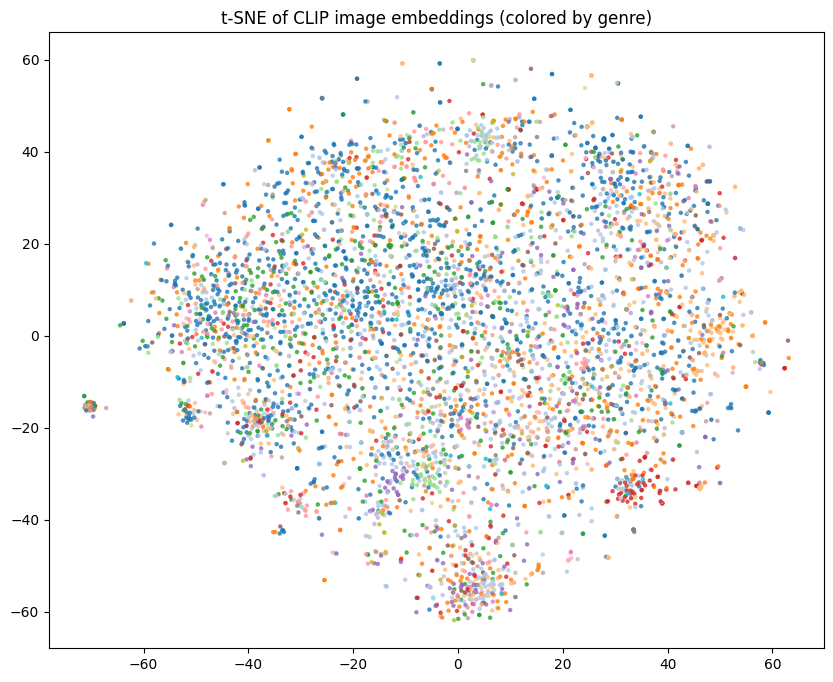

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
# Load embeddings (every row = one parent_asin with vector)
emb_df = pd.read_parquet("clip_img_emb_parent.parquet")
df = pd.read_parquet(f"reviews_with_img_emb_{category}.parquet")
emb_with_cat = emb_df.merge(
    df[["parent_asin", "categories"]], 
    on="parent_asin", 
    how="inner"
)

# Now extract embeddings + labels together
print(type(emb_with_cat["clip_img_emb"].values[0]), len(emb_with_cat))
X = np.stack(emb_with_cat["clip_img_emb"].values)
emb_with_cat["genre"] = emb_with_cat["categories"].apply(
    lambda x: x[-1] if len(x) > 0 else "Unknown"
)
labels = emb_with_cat["genre"]
print("Genre counts:", labels.value_counts().to_dict())

print("Shapes:", X.shape, len(labels))   
X_2d = TSNE(n_components=2, perplexity=30, metric="cosine", random_state=42).fit_transform(X)

plt.figure(figsize=(10,8))
plt.scatter(X_2d[:,0], X_2d[:,1],
            c=pd.factorize(labels)[0],
            cmap="tab20", s=5, alpha=0.7)
plt.title("t-SNE of CLIP image embeddings (colored by genre)")
plt.show()



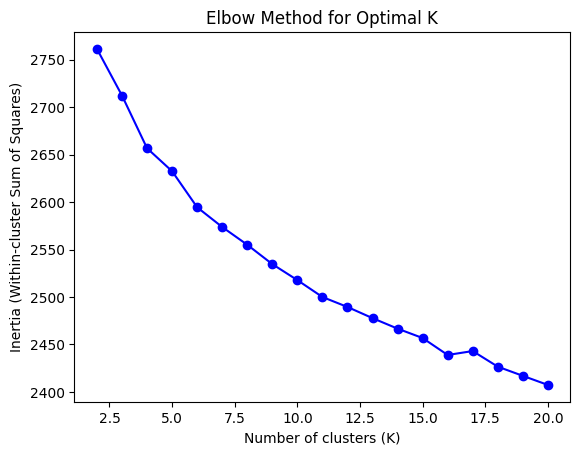

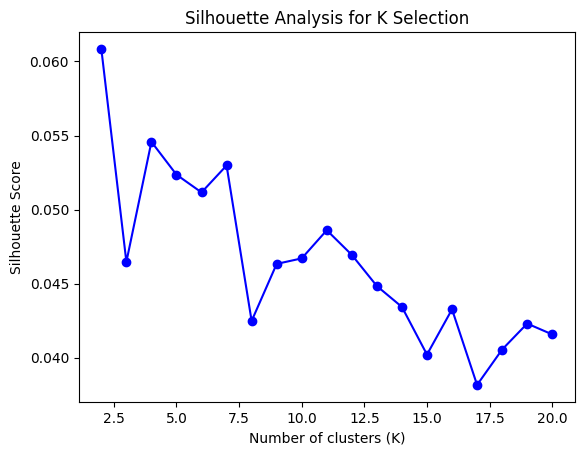

In [38]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score    

wcss = []
K_range = range(2, 21)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)   # X is your embedding matrix
    wcss.append(kmeans.inertia_)

plt.plot(K_range, wcss, 'bo-')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Inertia (Within-cluster Sum of Squares)')
plt.title('Elbow Method for Optimal K')
plt.show()

scores = []
for k in range(2, 21):
    kmeans = KMeans(n_clusters=k, random_state=42)
    preds = kmeans.fit_predict(X)
    score = silhouette_score(X, preds, metric='cosine')
    scores.append(score)

plt.plot(range(2, 21), scores, 'bo-')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis for K Selection')
plt.show()



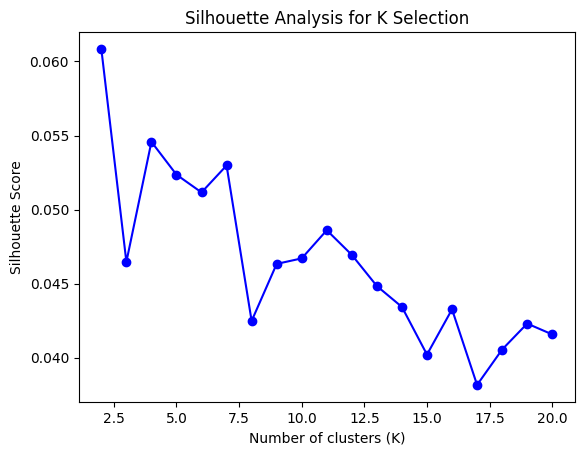

In [33]:
from sklearn.metrics import silhouette_score

scores = []
for k in range(2, 21):
    kmeans = KMeans(n_clusters=k, random_state=42)
    preds = kmeans.fit_predict(X)
    score = silhouette_score(X, preds, metric='cosine')
    scores.append(score)

plt.plot(range(2, 21), scores, 'bo-')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis for K Selection')
plt.show()


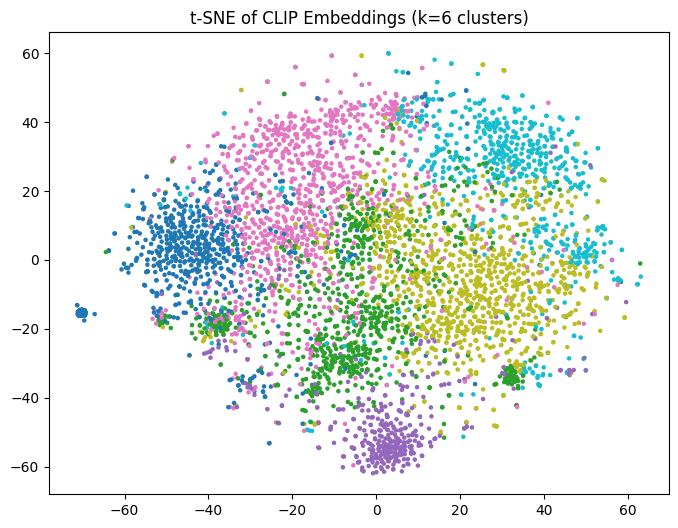

In [37]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=6, random_state=42)
clusters = kmeans.fit_predict(X)
plt.figure(figsize=(8,6))
plt.scatter(X_2d[:,0], X_2d[:,1], c=clusters, cmap="tab10", s=5)
plt.title("t-SNE of CLIP Embeddings (k=6 clusters)")
plt.show()


## K = 6  la phe nha ae, vì ở đây đang test xem cái embedding của CLIP có thực sự OK k, thì k = 6 cho ra khá tốt vì cluster được ra tốt và thực sự cái model CLIP chạy oke, k=6 vì lấy dựa trên 2 cái method Elbow với Silhoutte ở trên


In [ ]:
from sentence_transformers import SentenceTransformer
model_text = SentenceTransformer('all-MiniLM-L6-v2')
df.head()
text_emb = model_text.encode(df['title_x'].tolist(), batch_size=64, show_progress_bar=True)
print("Text embeddings shape:", text_emb.shape) 


# cái này là để chuẩn hoá vector, tức là đưa vector về cùng 1 độ dài, để khi tính cosine similarity thì nó sẽ đúng hơn, hình dung nó như là chuyển 1 câu review về một vector có 384 chiều

Batches:   0%|          | 0/79 [00:00<?, ?it/s]

Text embeddings shape: (5000, 384)


In [ ]:
from sklearn.preprocessing import normalize
from sklearn.neighbors import NearestNeighbors
import numpy as np
# Normalize the embeddings
E_txt = normalize(text_emb)   
# (N, D)

nbrs = NearestNeighbors(n_neighbors=10, metric="cosine").fit(E_txt)

def show_neighbors(idx, k=5):
    d, i = nbrs.kneighbors(E_txt[idx:idx+1], n_neighbors=k+1)
    return list(zip(i[0][1:], 1 - d[0][1:]))  # (neighbor_index, cosine_sim)

print(show_neighbors(123))


[(np.int64(1320), np.float32(0.72225344)), (np.int64(3928), np.float32(0.72225344)), (np.int64(2075), np.float32(0.6863226)), (np.int64(1867), np.float32(0.6810676)), (np.int64(4567), np.float32(0.6772847))]


In [49]:
from sklearn.preprocessing import normalize
E_img = normalize(df['clip_img_emb'].tolist())
E_txt = normalize(text_emb)
E_item = normalize(np.concatenate([E_txt, E_img], axis=1))
print("Item embeddings shape:", E_item.shape)


Item embeddings shape: (5000, 896)
